In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

In [2]:
# data pipeline

# read in file
raw_data = pd.read_csv("AmesHousing.csv", "~")

# see what has been loaded
raw_data.keys()

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "Lot Frontage", "Lot Area", 
                 "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", 
                 "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", 
                 "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", 
                 "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", 
                    "Bedroom AbvGr", "Garage Cars", "Yr Sold", "Overall Qual", "Lot Area", "Lot Frontage",
                   "Pool Area", "Fireplaces"]]

##############################################################################
# basement stuff                                                     #########
##############################################################################

# print data["Bsmt Qual"].unique()

boink = pd.get_dummies(data["Bsmt Qual"])
# [u'Ex', u'Fa', u'Gd', u'Po', u'TA']
boink.columns = ["bsmt_qual_ex", "bsmt_qual_fa", "bsmt_qual_gd", "bsmt_qual_po", "bsmt_qual_ta" ]

simple_data = pd.concat((simple_data, boink), axis=1)

##############################################################################
# pool data                                                          #########
##############################################################################

has_pool = np.array(simple_data.loc[:,"Pool Area"] > 0)
has_pool_df = pd.DataFrame(has_pool, columns=["has_pool"])
simple_data = pd.concat((simple_data, has_pool_df), axis=1)


##############################################################################
# use the oneHot encoder to create dummy columns for overall quality #########
##############################################################################
encoder = OneHotEncoder()
temp = simple_data["Overall Qual"]
overall_qual_dummies = encoder.fit_transform(temp.values.reshape(-1, 1))
overall_qual_dummies = overall_qual_dummies.toarray()
print "overall_qual_dummies shape:", overall_qual_dummies.shape

oq_dummies = pd.DataFrame(overall_qual_dummies, columns=["oq_1", "oq_2", "oq_3", "oq_4", "oq_5", "oq_6", 
                                                         "oq_7", "oq_8", "oq_9", "oq_10"])
# print oq_dummies.head()

simple_data = pd.concat((simple_data, oq_dummies), axis=1)
simple_data.pop("Overall Qual")


# Fuzzing Quality seemed to hurt accuracy, perhaps because there wasn't a super dominant feature
# print simple_data.keys()
# simple_data.loc["Overall Qual"] = simple_data[simple_data["Overall Qual"] + np.random.uniform(-0.001, 0.001, size=len(simple_data))]
# simple_data.loc[:, "Overall Qual"] += np.random.normal(-0.001, 0.001, size=1)


##############################################################################
# Figure out Square footage information                              #########
##############################################################################
# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.pop(0)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

simple_data["Lot Frontage"].fillna(simple_data["Lot Frontage"].mean(), inplace=True)

##############################################################################
# Create "lot_ratio" which is "Lot Area" / "Lot Frontage"            #########
##############################################################################
simple_data.loc[:, "lot_length"] = simple_data.loc[:,"Lot Area"] / (simple_data.loc[:, "Lot Frontage"] * 1.0)

simple_data.loc[:, "lot_ratio"] = simple_data.loc[:,"Lot Frontage"] / (simple_data.loc[:, "lot_length"] * 1.0)
simple_data.pop("lot_length")

##############################################################################
# Bathroom feature manipulation                                      #########
##############################################################################
# combine bathroom stats
simple_data.loc[:, "total_baths"] = simple_data.loc[:, "Full Bath"] + simple_data.loc[:, "Half Bath"]

simple_data["total_baths"] = simple_data["total_baths"].mask(simple_data["total_baths"] == 0, 0.1)

simple_data.loc[:, "bed_to_bath"] = simple_data.loc[:, "Bedroom AbvGr"] / (simple_data.loc[:, "total_baths"] * 1.0)

############################################################################## 
# Pop out pricing labels                                             #########
##############################################################################
Y = simple_data.loc[:,"SalePrice"]

##############################################################################
# Print out basic info for constructed dataframe                     #########
##############################################################################
simple_data.pop("SalePrice")
print simple_data.describe()

print
print simple_data.info()

##############################################################################
# Track Feature Engineering Evolution                                #########
##############################################################################

# try to fuzz "Overall Qual" so that it can't totally drill in on any particular value
# Starting ensemble with "simple_data" 
# Mean RMSE of 10 Runs:54667.0
#
# Add "Overall Qual" feature
# Mean RMSE of 10 Runs:46235.5
#
# Fuzzed "Overall Qual" Feature
# Mean RMSE of 10 Runs:46102.1
#
# Dummified "Overall Qual" feature
# Mean RMSE of 10 Runs:46572.3
# really helped RandomForests and LinearRegression though
#
# Tuned Gradient Boosting Hyper Parameters with quality dummies disabled
# Mean RMSE of 10 Runs:37670.7
#
# Enabled Dummified overall quality
# Mean RMSE of 10 Runs:38282.8
#
# Modified splitting to keep 20% of original data for use as validation set to prevent
# overall overfitting because the model tuning is being run so many times
# Mean RMSE of 10 Runs:38118.5
#
# Include "Lot Area" feature
# Mean RMSE of 10 Runs:36766.1
#
# Include "Lot Frontage" feature
# Mean RMSE of 10 Runs:34989.0
#
# Create "lot_length" feature "Lot Area" / "Lot Frontage"
# Mean RMSE of 10 Runs:37455.6
#
# Create "lot_ratio" which is "Lot Frontage" / "lot_length"
# Mean RMSE of 10 Runs:35728.2
#
# Create "total_baths"
# Mean RMSE of 10 Runs:36547.2
#
# Tuned DecisionTree max_depth hyper parameter to 7
# Mean RMSE of 10 Runs:34161.9
#
# Fireplaces
# Mean RMSE of 10 Runs:34219.6
#
# bed_to_bath ratio
# Mean RMSE of 10 Runs:33950.7
#
# basement quality dummy columns
# Mean RMSE of 10 Runs:34915.2
#
# removed basement quality dummy columns
# Mean RMSE of 10 Runs:34795.2
#
# Added Ridge model to ensemble, re-enabled pool and basement
# Mean RMSE of 10 Runs:34116.1

overall_qual_dummies shape: (2930, 10)
        Year Built    Full Bath    Half Bath  Bedroom AbvGr  Garage Cars  \
count  2930.000000  2930.000000  2930.000000    2930.000000  2930.000000   
mean   1971.356314     1.566553     0.379522       2.854266     1.766212   
std      30.245361     0.552941     0.502629       0.827731     0.761137   
min    1872.000000     0.000000     0.000000       0.000000     0.000000   
25%    1954.000000     1.000000     0.000000       2.000000     1.000000   
50%    1973.000000     2.000000     0.000000       3.000000     2.000000   
75%    2001.000000     2.000000     1.000000       3.000000     2.000000   
max    2010.000000     4.000000     2.000000       8.000000     5.000000   

           Yr Sold       Lot Area  Lot Frontage    Pool Area   Fireplaces  \
count  2930.000000    2930.000000   2930.000000  2930.000000  2930.000000   
mean   2007.790444   10147.921843     69.224590     2.243345     0.599317   
std       1.316613    7880.017759     21.3215

In [16]:
print raw_data.info()

print raw_data.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

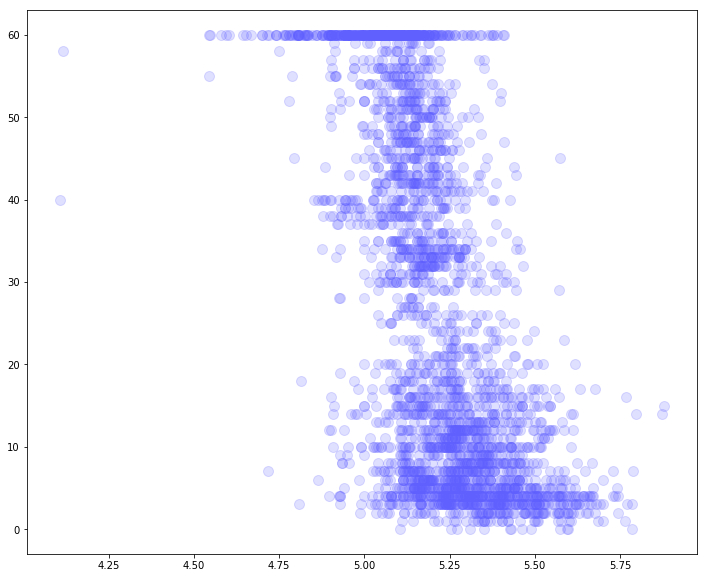

In [48]:
info = raw_data["Year Built"]
info2 = raw_data["Year Remod/Add"]

# print info2.max()
# # most recently modified
# boink = pd.concat((info, info2), axis=1)
# print boink.head(50)

years_since_update = 2010 - info2 + np.random.normal(-0.001, .001, size=1)

# info = np.log10(info)
info2 = raw_data["Half Bath"]
prices = raw_data["SalePrice"]
prices = np.log10(prices)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(prices, years_since_update, alpha=0.2, s=100, color="#6060FF")
# ax.scatter(prices, info2 + 0.1, alpha=0.2, s=100, color="#88FF88")

(array([   2.,    0.,    0.,    0.,    0.,    0.,    6.,    3.,    8.,
          24.,   26.,  103.,  133.,  329.,  565.,  474.,  436.,  320.,
         213.,  138.,   80.,   43.,   14.,   11.,    2.]),
 array([ 4.10683659,  4.177681  ,  4.24852542,  4.31936983,  4.39021425,
         4.46105866,  4.53190307,  4.60274749,  4.6735919 ,  4.74443632,
         4.81528073,  4.88612515,  4.95696956,  5.02781398,  5.09865839,
         5.16950281,  5.24034722,  5.31119164,  5.38203605,  5.45288046,
         5.52372488,  5.59456929,  5.66541371,  5.73625812,  5.80710254,
         5.87794695]),
 <a list of 25 Patch objects>)

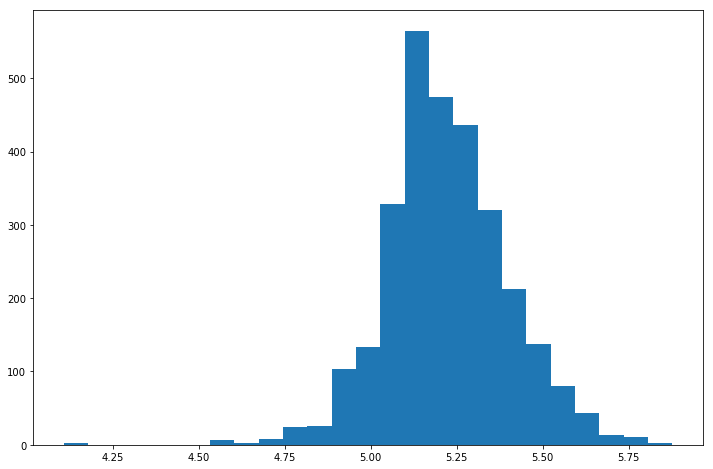

In [31]:
fig, bx = plt.subplots(figsize=(12,8))
bx.hist(np.log10(prices), bins=25)

In [3]:
print raw_data.keys()

Index([u'Order', u'PID', u'MS SubClass', u'MS Zoning', u'Lot Frontage',
       u'Lot Area', u'Street', u'Alley', u'Lot Shape', u'Land Contour',
       u'Utilities', u'Lot Config', u'Land Slope', u'Neighborhood',
       u'Condition 1', u'Condition 2', u'Bldg Type', u'House Style',
       u'Overall Qual', u'Overall Cond', u'Year Built', u'Year Remod/Add',
       u'Roof Style', u'Roof Matl', u'Exterior 1st', u'Exterior 2nd',
       u'Mas Vnr Type', u'Mas Vnr Area', u'Exter Qual', u'Exter Cond',
       u'Foundation', u'Bsmt Qual', u'Bsmt Cond', u'Bsmt Exposure',
       u'BsmtFin Type 1', u'BsmtFin SF 1', u'BsmtFin Type 2', u'BsmtFin SF 2',
       u'Bsmt Unf SF', u'Total Bsmt SF', u'Heating', u'Heating QC',
       u'Central Air', u'Electrical', u'1st Flr SF', u'2nd Flr SF',
       u'Low Qual Fin SF', u'Gr Liv Area', u'Bsmt Full Bath',
       u'Bsmt Half Bath', u'Full Bath', u'Half Bath', u'Bedroom AbvGr',
       u'Kitchen AbvGr', u'Kitchen Qual', u'TotRms AbvGrd', u'Functional',
       u'Fi

In [4]:
raw_data.PID.head()

0    526301100
1    526350040
2    526351010
3    526353030
4    527105010
Name: PID, dtype: int64

In [18]:
pids = raw_data.PID.iloc[0:10]

print pids

# format string into pid
# example PID: 05-22-160-070
# example data PID: 526301100
# converted: 05-26-301-100
for test in pids:
    test = str(test)
    print "{}-{}-{}-{}".format("0" + test[0], test[1:3], test[3:6], test[6:])

0    526301100
1    526350040
2    526351010
3    526353030
4    527105010
5    527105030
6    527127150
7    527145080
8    527146030
9    527162130
Name: PID, dtype: int64
05-26-301-100
05-26-350-040
05-26-351-010
05-26-353-030
05-27-105-010
05-27-105-030
05-27-127-150
05-27-145-080
05-27-146-030
05-27-162-130


In [19]:
len(raw_data)

2930